In [485]:
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
%matplotlib inline

### Reading Data and Dropping Duplicates

In [486]:
table = pd.read_json("modifiedData.json")
table.drop_duplicates(inplace=True, ignore_index=True)
table.shape
table

,,bathrooms,bedrooms,hometype,latitude,longitude,price,lotAreaValue
0,0.0,7.0,7,SINGLE_FAMILY,43.685574,-79.448690,1849000,2506.2539
1,1.0,1.0,1,CONDO,43.618538,-79.485100,585000,
2,2.0,1.0,2,CONDO,43.630337,-79.472730,794500,
3,3.0,3.0,3,SINGLE_FAMILY,43.644554,-79.421234,3799000,2343.75
4,4.0,2.0,3,CONDO,43.722080,-79.543945,489999,
...,...,...,...,...,...,...,...,...
814,NaN,1.0,2,CONDO,43.624832,-79.488785,599900,NaN
815,NaN,3.0,4,CONDO,43.629436,-79.477325,2989000,NaN
816,NaN,1.0,1,CONDO,43.627470,-79.477130,619000,NaN
817,NaN,2.0,2,CONDO,43.748512,-79.286070,649900,NaN


### Applying One Hot Encoding to The Hometype Category

In [487]:
one_hot_encoded_data = pd.get_dummies(table, columns=['hometype'])
one_hot_encoded_data

,,bathrooms,bedrooms,latitude,longitude,price,lotAreaValue,hometype_APARTMENT,hometype_CONDO,hometype_LOT,hometype_MULTI_FAMILY,hometype_SINGLE_FAMILY,hometype_TOWNHOUSE
0,0.0,7.0,7,43.685574,-79.448690,1849000,2506.2539,0,0,0,0,1,0
1,1.0,1.0,1,43.618538,-79.485100,585000,,0,1,0,0,0,0
2,2.0,1.0,2,43.630337,-79.472730,794500,,0,1,0,0,0,0
3,3.0,3.0,3,43.644554,-79.421234,3799000,2343.75,0,0,0,0,1,0
4,4.0,2.0,3,43.722080,-79.543945,489999,,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,NaN,1.0,2,43.624832,-79.488785,599900,NaN,0,1,0,0,0,0
815,NaN,3.0,4,43.629436,-79.477325,2989000,NaN,0,1,0,0,0,0
816,NaN,1.0,1,43.627470,-79.477130,619000,NaN,0,1,0,0,0,0
817,NaN,2.0,2,43.748512,-79.286070,649900,NaN,0,1,0,0,0,0


In [488]:
table = one_hot_encoded_data.rename(columns={'hometype_APARTMENT': 'isApartment', 'hometype_CONDO': 'isCondo', 'hometype_LOT': 'isLot',
                                    'hometype_MULTI_FAMILY': 'isMultiFamily', 'hometype_SINGLE_FAMILY': 'isSingleFamily', 'hometype_TOWNHOUSE': 'isTownHouse'})
table = table.dropna()
table

,,bathrooms,bedrooms,latitude,longitude,price,lotAreaValue,isApartment,isCondo,isLot,isMultiFamily,isSingleFamily,isTownHouse
0,0.0,7.0,7,43.685574,-79.448690,1849000,2506.2539,0,0,0,0,1,0
1,1.0,1.0,1,43.618538,-79.485100,585000,,0,1,0,0,0,0
2,2.0,1.0,2,43.630337,-79.472730,794500,,0,1,0,0,0,0
3,3.0,3.0,3,43.644554,-79.421234,3799000,2343.75,0,0,0,0,1,0
4,4.0,2.0,3,43.722080,-79.543945,489999,,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,610.0,2.0,4,43.655865,-79.570600,639900,,0,1,0,0,0,0
611,611.0,2.0,3,43.641720,-79.381500,909000,,0,1,0,0,0,0
612,612.0,2.0,3,43.703022,-79.395820,899000,,0,1,0,0,0,0
613,613.0,2.0,2,43.646015,-79.394066,739999,,0,1,0,0,0,0


### Selecting the Columns That Will Be Used To Fit The Models

In [489]:
table = table[['bathrooms', 'bedrooms', 'latitude', 'longitude', 'isApartment', 'isCondo', 'isLot', 'isMultiFamily', 'isSingleFamily', 'isTownHouse', 'price']]
table

,bathrooms,bedrooms,latitude,longitude,isApartment,isCondo,isLot,isMultiFamily,isSingleFamily,isTownHouse,price
0,7.0,7,43.685574,-79.448690,0,0,0,0,1,0,1849000
1,1.0,1,43.618538,-79.485100,0,1,0,0,0,0,585000
2,1.0,2,43.630337,-79.472730,0,1,0,0,0,0,794500
3,3.0,3,43.644554,-79.421234,0,0,0,0,1,0,3799000
4,2.0,3,43.722080,-79.543945,0,1,0,0,0,0,489999
...,...,...,...,...,...,...,...,...,...,...,...
610,2.0,4,43.655865,-79.570600,0,1,0,0,0,0,639900
611,2.0,3,43.641720,-79.381500,0,1,0,0,0,0,909000
612,2.0,3,43.703022,-79.395820,0,1,0,0,0,0,899000
613,2.0,2,43.646015,-79.394066,0,1,0,0,0,0,739999


In [490]:
table['price'].max()

12288000

### Dropping Incompelete Data Points

In [491]:
table.drop(index=[165, 260, 381, 426, 607], axis=0, inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_24396\518583155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.drop(index=[165, 260, 381, 426, 607], axis=0, inplace=True)


In [492]:
table.shape

(610, 11)

In [493]:
table['bedrooms'] = pd.to_numeric(table['bedrooms'])

C:\Users\admin\AppData\Local\Temp\ipykernel_24396\2291959289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['bedrooms'] = pd.to_numeric(table['bedrooms'])


In [494]:
X = table.to_numpy()[:, 0:10]
Y = table['price']
X.shape

(610, 10)

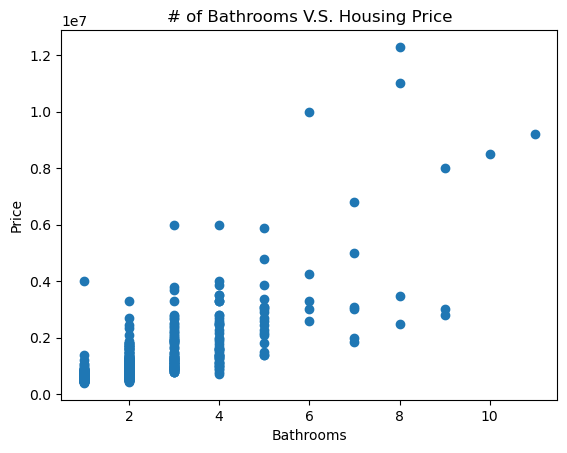

In [495]:
plt.scatter(X[:,0], Y);
plt.xlabel("Bathrooms");
plt.ylabel("Price");
plt.title("# of Bathrooms V.S. Housing Price");

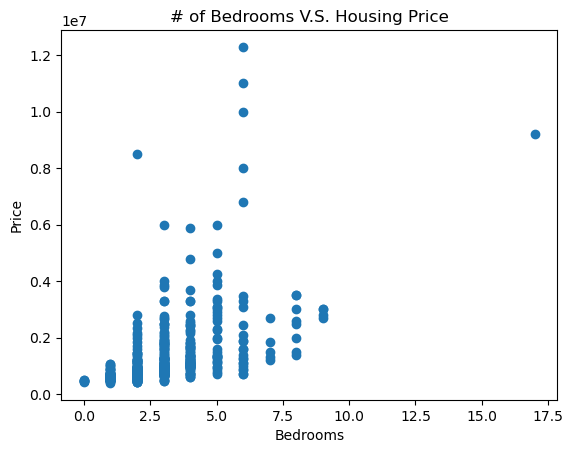

In [496]:
plt.scatter(X[:, 1:2], Y);
plt.xlabel("Bedrooms");
plt.ylabel("Price");
plt.title("# of Bedrooms V.S. Housing Price");

# Linear Regression

### Training And Fitting The Data To The Linear Regression Model

In [497]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [498]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

### Predicting The Test Set And Evaluating The Model

In [499]:
y_pred_reg = reg.predict(X_test)
y_pred_reg

array([5037274.73803659,  447314.83769739,  526910.12901814,
        823386.84799522,  233848.36893821, 1032343.69682249,
       2115263.70872338,  357927.22468607,  543696.46021046,
       2139643.59305699, 1259864.0339601 , 1297389.34013972,
       3223413.67565997,  569443.43567178, 1205322.15349329,
       1830228.50107099, 1041126.22860789, 2175133.42017721,
       1499387.89002366, 1362733.7344683 , 1804765.53194822,
       1080979.97994372, 1215117.03927439,  583040.28839666,
        482533.85631755,  779761.24247797, 2381702.62744655,
       2147662.04785028,  381157.7269045 , 1181647.5294295 ,
       1290575.56135766,  195468.22431903, 1850945.55192836,
        861539.80416141,  842535.99661931, 1858699.39243256,
        673296.68258156,  352090.74750093, 2581771.63957816,
        465450.09615639,  960051.28866926,  841519.12533991,
       1903058.79168677, 2609712.5441284 , 1197146.60298131,
        540542.24854921,  364615.10708927,  897007.66094856,
        662480.82551612,

In [500]:
print("Explained Variance By The Model:", explained_variance_score(y_test, y_pred_reg))

Explained Variance By The Model: 0.48251852452211563


In [501]:
print("R2 Score:", r2_score(y_test, y_pred_reg))

R2 Score: 0.4814261397449079


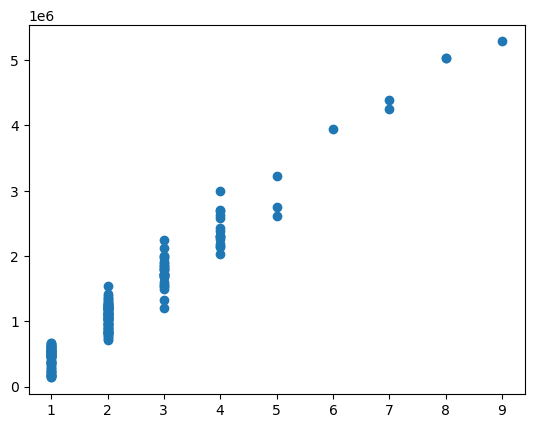

In [502]:
plt.scatter(X_test[:, 0], y_pred_reg);

In [503]:
reg.coef_

array([ 6.69204334e+05, -6.67130567e+04, -2.71548463e+06,  7.45641363e+04,
       -7.93625656e+04, -2.08843637e+05,  3.49245965e-10,  6.35033150e+05,
        7.65067523e+04, -4.23333700e+05])

### Making Predictions On Recent House Listings On Realtor

Making Predictions On Lower Price Listings (Apartments, Houses)

In [504]:
#https://www.realtor.ca/real-estate/26442179/24-keegan-cres-toronto-york-university-heights
new_house = [[2, 3, 43.752420, -79.506990, 0, 0, 0, 0, 1, 0]]
new_pred = reg.predict(new_house)
actual_price = 1,199,999
error = new_pred[0] - actual_price
print("Error:", error[0])

Error: 1118421.7132289708


In [505]:
#https://www.realtor.ca/real-estate/26442127/911-286-main-st-toronto-east-end-danforth
new_condo = [[1, 2, 43.68767064395922, -79.30169444801489, 1, 0, 0, 0, 1, 0]]
condo_pred_reg = reg.predict(new_condo)
actual_price = 619900
error = condo_pred_reg[0] - actual_price
print("Error:", error)

Error: 7802.437281027436


In [506]:
print("Predicted Price:", condo_pred_reg[0])

Predicted Price: 627702.4372810274


In [507]:
#https://www.realtor.ca/real-estate/26442106/22-6-sonic-way-toronto-flemingdon-park
new_condo1 = [[1, 2, 43.72176413078892, -79.33670866093503, 1, 0, 0, 0, 1, 0]]
condo_pred1_reg = reg.predict(new_condo1)
actual_price = 550000
error = condo_pred1_reg[0] - actual_price
print("Error:", error)

Error: -17488.706798493862


In [508]:
print("Predicted Price:", condo_pred1_reg[0])

Predicted Price: 532511.2932015061


Making Predictions On Higher Price Listings (Houses)

In [509]:
#https://www.realtor.ca/real-estate/26381619/38-salonica-rd-toronto-bridle-path-sunnybrook-york-mills
expensive_house = [[11, 8, 43.727395026061906, -79.35498156150294, 0, 0, 0, 0, 1, 0]]
expensive_pred_reg = reg.predict(expensive_house)
actual_price = 12880000
error = expensive_pred_reg[0] - actual_price
print("Error:", error)

Error: -5993014.255680099


In [510]:
print("Predicted Price:", expensive_pred_reg[0])

Predicted Price: 6886985.744319901


In [511]:
#https://www.realtor.ca/real-estate/26237212/16-fifeshire-rd-toronto-st-andrew-windfields
expensive_house1 = [[8, 5, 43.754592649734946, -79.38834095017624, 0, 0, 0, 0, 1, 0]]
expensive1_pred_reg = reg.predict(expensive_house1)
actual_price = 8880000
error = expensive1_pred_reg[0] - actual_price
print("Error:", error)

Error: -3876830.2301354855


In [512]:
print("Predicted Price:", expensive1_pred_reg[0])

Predicted Price: 5003169.7698645145


# XGBOOST

### Training And Fitting The Data To The XGBOOST Model

In [513]:
XGB = XGBRegressor()
XGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Predicting The Test Set And Evaluating The Model

In [514]:
y_pred_XGB = XGB.predict(X_test)
y_pred_XGB

array([ 3760567.2 ,  1174014.  ,   672180.75,  1066214.9 ,   527768.44,
        1068490.1 ,  1581186.8 ,   563346.  ,   887384.25,  2773647.8 ,
        1028165.56,   886854.9 ,  2006303.4 ,  1096959.4 ,   740900.56,
        1198034.5 ,   775884.06,  1602775.1 ,  2524848.  ,   988951.1 ,
        2645105.  ,   989347.7 ,   741998.94,   622329.2 ,   828678.8 ,
         630363.6 ,  2629631.2 ,   908379.7 ,   476672.16,   888496.3 ,
        1007188.9 ,   644538.3 ,  1074830.4 ,   561767.75,   615750.7 ,
        2348500.  ,   566975.06,   578954.44,  2311485.5 ,   786776.6 ,
        1030887.25,   983477.7 ,  1542662.8 ,  2240730.5 ,   802206.56,
         650287.06,   979049.5 ,   893262.75,   617424.25,  7610975.  ,
         623561.  ,   497897.7 ,  2040376.6 ,   547593.4 ,   606729.8 ,
        1012308.25,   582546.7 ,   770527.9 ,  1475883.2 ,  2424371.8 ,
         764790.  ,   532828.1 ,   693853.2 ,   832198.  ,   344696.84,
         688262.2 ,   706313.9 ,  1009963.9 ,   824067.2 ,  1408

In [515]:
print("Explained Variance By The Model:", explained_variance_score(y_test, y_pred_XGB))

Explained Variance By The Model: 0.8377190104898029


In [516]:
print("R2 Score:", r2_score(y_test, y_pred_XGB))

R2 Score: 0.8372382409412408


### Making Predictions On Recent House Listings On Realtor

Making Predictions On Lower Price Listings (Apartments)

In [517]:
#https://www.realtor.ca/real-estate/26442179/24-keegan-cres-toronto-york-university-heights
XGB_pred = XGB.predict(new_house)
actual_price = 1,199,999
error = XGB_pred[0] - 1199999
print("Error:", error)

Error: -159889.1875


In [518]:
#https://www.realtor.ca/real-estate/26442127/911-286-main-st-toronto-east-end-danforth
new_condo = [[1, 2, 43.68767064395922, -79.30169444801489, 1, 0, 0, 0, 1, 0]]
condo_pred_XGB = XGB.predict(new_condo)
actual_price = 619900
error = condo_pred_XGB[0] - actual_price
print("Error:", error)

Error: 2591416.25


In [519]:
print("Predicted Price:", condo_pred_XGB[0])

Predicted Price: 3211316.2


In [520]:
#https://www.realtor.ca/real-estate/26442106/22-6-sonic-way-toronto-flemingdon-park
new_condo1 = [[1, 2, 43.72176413078892, -79.33670866093503, 1, 0, 0, 0, 1, 0]]
condo_pred1_XGB = XGB.predict(new_condo1)
actual_price = 550000
error = condo_pred1_XGB[0] - actual_price
print("Error:", error)

Error: 2741167.75


Making Predictions On Higher Price Listings (Houses)

In [521]:
#https://www.realtor.ca/real-estate/26381619/38-salonica-rd-toronto-bridle-path-sunnybrook-york-mills
expensive_house = [[11, 8, 43.727395026061906, -79.35498156150294, 0, 0, 0, 0, 1, 0]]
expensive_pred_XGB = XGB.predict(expensive_house)
actual_price = 12880000
error = expensive_pred_XGB[0] - actual_price
print("Error:", error)

Error: -4019810.0


In [522]:
print("Predicted Price:", expensive_pred_XGB[0])

Predicted Price: 8860190.0


In [523]:
#https://www.realtor.ca/real-estate/26237212/16-fifeshire-rd-toronto-st-andrew-windfields
expensive_house1 = [[8, 5, 43.754592649734946, -79.38834095017624, 0, 0, 0, 0, 1, 0]]
expensive1_pred_XGB = XGB.predict(expensive_house1)
actual_price = 8880000
error = expensive1_pred_XGB[0] - actual_price
print("Error:", error)

Error: 581164.0


In [524]:
print("Predicted Price:", expensive1_pred_XGB[0])

Predicted Price: 9461164.0


# Summary

Linear Regression performs better on houses with lower prices, while XGBOOST performs better on houses with higher prices